In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from einops import rearrange
from tqdm import tqdm

from viv1t.data import MOUSE_IDS
from viv1t.data import SENSORIUM_OLD
from viv1t.data import get_tier_ids
from viv1t.data import load_trial
from viv1t.utils import plot

plot.set_font()

DATA_DIR = Path("../data/sensorium")

In [2]:
def load_responses(mouse_id: str, tier: str):
    mouse_dir = DATA_DIR / MOUSE_IDS[mouse_id]
    tiers = get_tier_ids(data_dir=DATA_DIR, mouse_id=mouse_id)
    trial_ids = np.where(tiers == tier)[0]
    stats, values = [], []
    for trial_id in trial_ids:
        sample = load_trial(mouse_dir, trial_id=trial_id, to_tensor=False)
        response = rearrange(sample["response"], "n t -> (n t)")
        stats.append("min")
        values.append(np.min(response))
        stats.append("max")
        values.append(np.max(response))
        stats.append("mean")
        values.append(np.mean(response))
        stats.append("std")
        values.append(np.std(response))
    n = len(stats)
    return pd.DataFrame(
        data={
            "mouse": [mouse_id] * n,
            "tier": [tier] * n,
            "stat": stats,
            "value": values,
        }
    )

In [3]:
df = None

for mouse_id in tqdm(SENSORIUM_OLD, desc="mouse"):
    for tier in (
        "train",
        "validation",
        "live_main",
        "live_bonus",
        "final_main",
        "final_bonus",
    ):
        mouse_df = load_responses(mouse_id, tier)
        df = mouse_df if df is None else pd.concat([df, mouse_df])

df

mouse: 100%|██████████| 5/5 [00:34<00:00,  6.84s/it]


,mouse,tier,stat,value
0,A,train,min,-2.691716e-07
1,A,train,max,1.603973e+03
2,A,train,mean,4.353283e+00
3,A,train,std,2.513598e+01
4,A,train,min,-2.539583e-07
...,...,...,...,...
543,E,final_bonus,std,1.585260e+01
544,E,final_bonus,min,-6.841053e-08
545,E,final_bonus,max,1.910752e+03
546,E,final_bonus,mean,3.444548e+00


In [63]:
def violin_plot(df: pd.DataFrame, stat: str):
    figure, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=200)
    data = df[df["stat"] == stat]
    sns.boxplot(
        data=data,
        x="mouse",
        y="value",
        hue="tier",
        fill=False,
        palette="Set2",
        gap=0.2,
        notch=True,
        flierprops={"marker": ".", "markersize": 5},
        ax=ax,
    )
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, 1.2),
        ncols=3,
        frameon=False,
        handletextpad=0.35,
        handlelength=0.6,
        markerscale=0.8,
        columnspacing=1,
        # bbox_transform=ax.transData,
    )
    # ax.set_ylim(0.95 * v_min, 1.1 * v_max)
    ax.set_xticks(ticks=range(0, 5), labels=SENSORIUM_OLD)
    ax.set_xlabel("Mouse", labelpad=0)
    ax.set_ylabel(f"Response {stat}", labelpad=0)
    # ax.set_title(f"Response distribution ({stat})")
    sns.despine(top=True, right=True, trim=False, ax=ax)
    plot.set_ticks_params(ax, length=2, pad=1)
    plt.show()

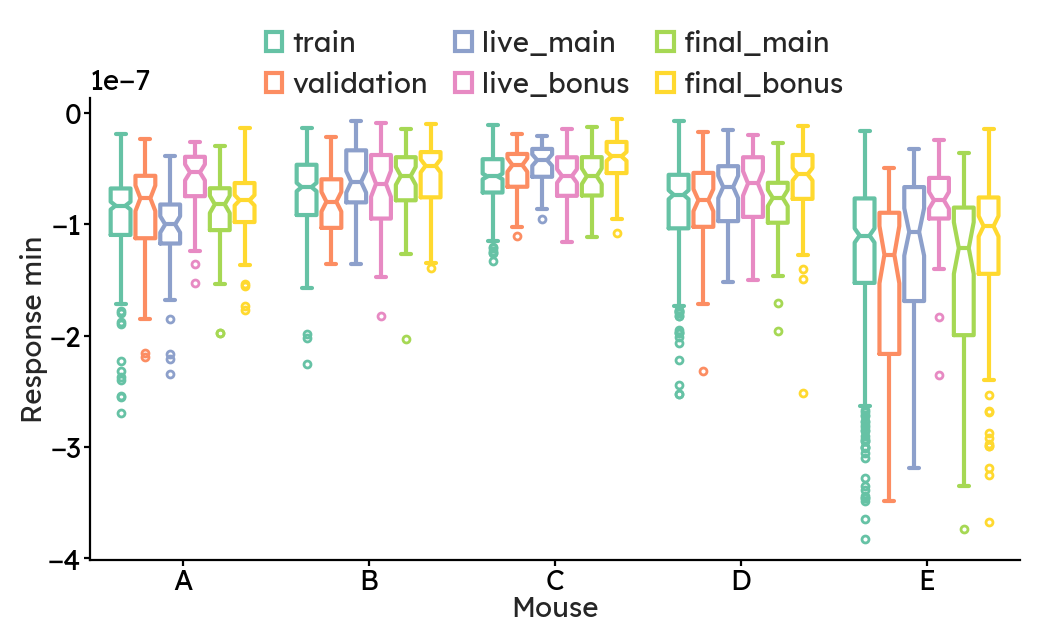

In [64]:
violin_plot(df, stat="min")

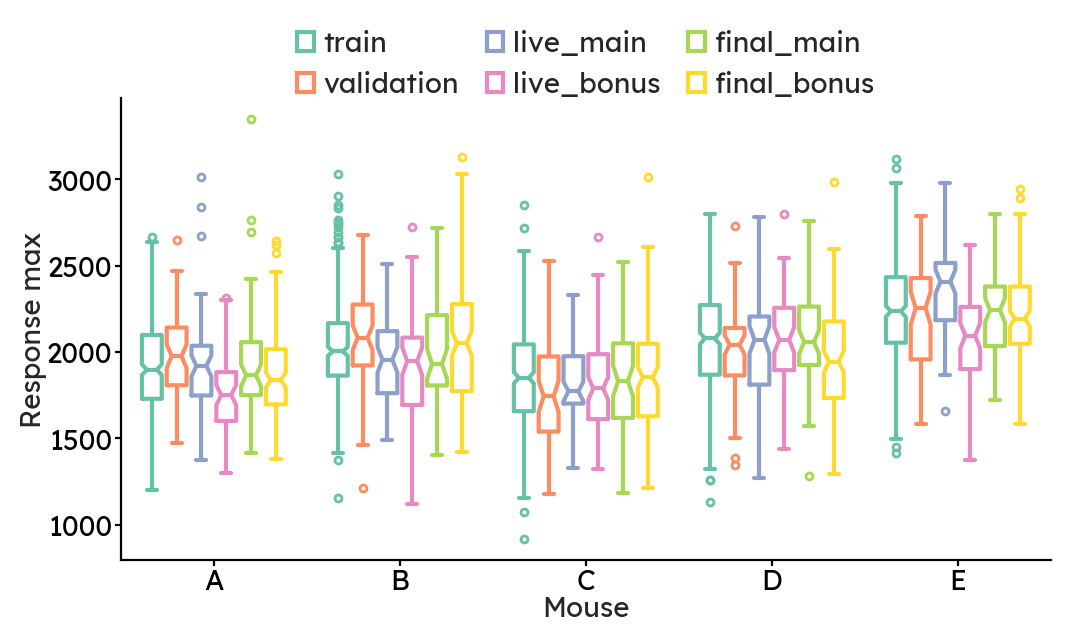

In [65]:
violin_plot(df, stat="max")

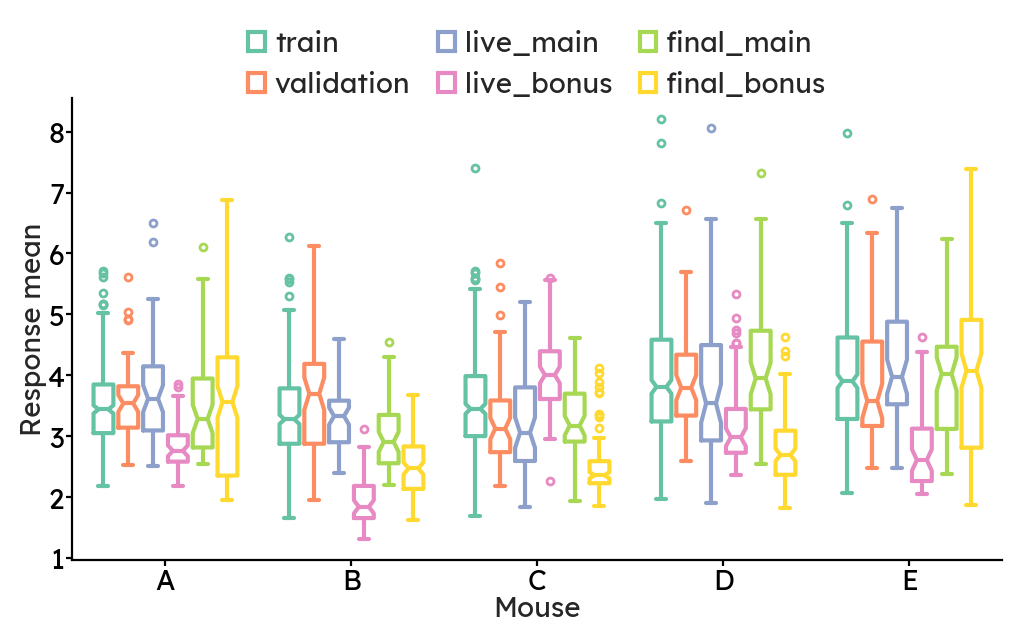

In [66]:
violin_plot(df, stat="mean")

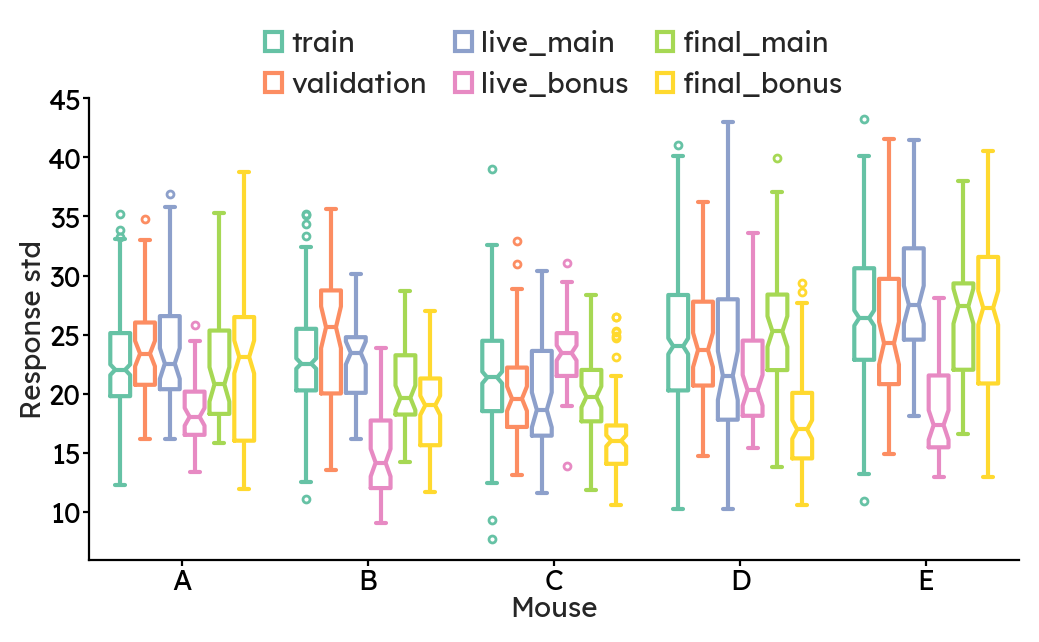

In [67]:
violin_plot(df, stat="std")